In [1]:
import numpy as np
import os
from emnist import extract_training_samples,extract_test_samples,list_datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.neural_network import MLPClassifier
import keras_tuner as kt
from tensorflow import keras
import keras_metrics
from PIL import Image

In [2]:
#Do not edit seed, for consistency sake in the train test splitting!
seed = 2002
np.random.seed(seed)


Because I could not find any documentation of the EMNIST Package, will split training data (80/20) to 
create a validation set for later hyperparameter tuning

We want to use the byclass set because that has all 0-10,A-Z,a-z labels
However, I know that the merge set exists to clear up confusion between lowercase and uppercase letters 
that look similar when handwritten (such as C/c and c or Z/z)

All datasets = balanced, byclass, bymerge, digits, letters, mnist

Without stratification, splits could become unbalanced in favor/against particular classes. Using stratify attribute
the splits will be balanced. This way our model should be able to train more evenly for all classes.


In [3]:
training_images, training_labels = extract_training_samples('byclass')
test_images, test_labels = extract_training_samples('byclass')

training_images = training_images/255.0
test_images = test_images/255.0
    
print("Training images shape",training_images.shape,"Training Labels shape",training_labels.shape)

training_images, val_images, training_labels, val_labels = train_test_split(training_images,training_labels,
                                        test_size=0.20, random_state=seed, shuffle =True,stratify=training_labels)
#print("\nAfter Split")
#print("Training:\nImages",training_images.shape,"Labels",training_labels.shape) 
#print("Validation:\nImages",val_images.shape,"Labels",val_labels.shape)
#print(training_labels[0:4])
#print(training_images[0])


Training images shape (697932, 28, 28) Training Labels shape (697932,)


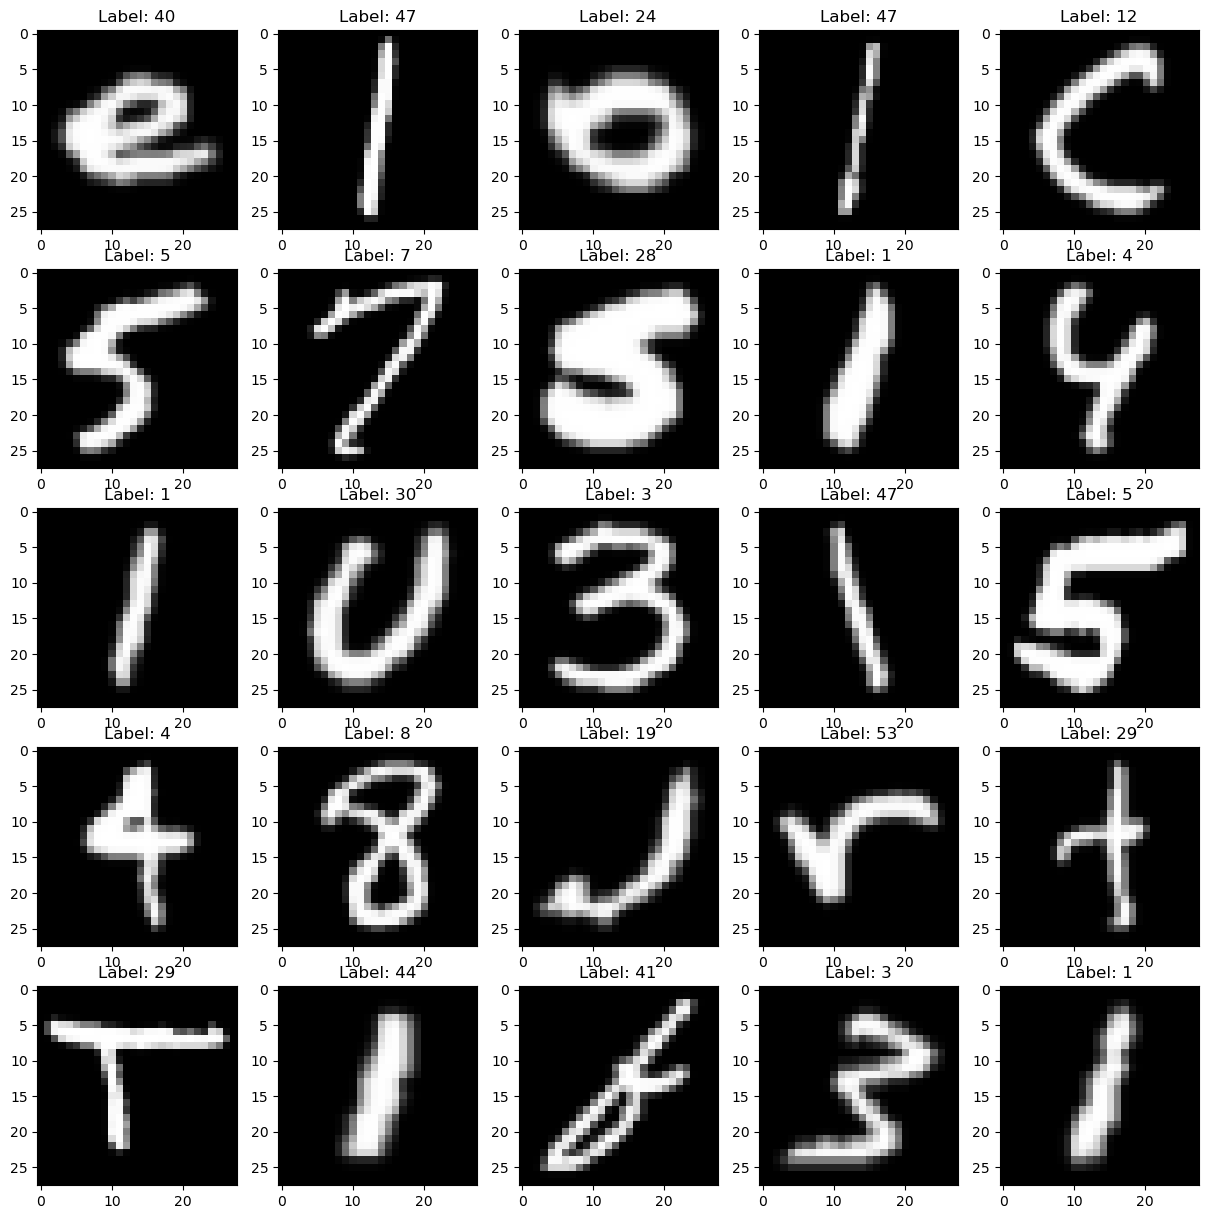

In [4]:
#I want to see what some of the data looks like using matplotlib. More visual representation.
#CLASSES ARE NUMBERS. 0-10 FIRST, THEN A-Z, THEN a-z
plt.rcParams['image.interpolation'] = 'nearest' #https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
plt.rcParams['image.cmap'] = 'gray' #the numbers will be shown in white-gray-black

figure, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    image = training_images[i].reshape(28, 28)
    axes[i//5, i%5].imshow(image)
    label = training_labels[i]
    axes[i//5, i%5].set_title(f'Label: {label}')
    

First, I want to manually create a MLP model using Sequential from tensorflow.
For now, NN architecture as a hyperparameter will be manually messed around with. 
Hidden Layer sizes are chosen to be arbitrary numbers that are slightly larger than half of the previous layer

In [ ]:
model = keras.Sequential(name="Handwriting_Recognition_Neural_Network") 
model.add(keras.layers.Flatten(input_shape=(28,28),name="Input_Layer")) #28*28 = 784 pixels/features to use
model.add(keras.layers.Dense(1000,activation='relu', name="Hidden_Layer_1"))
model.add(keras.layers.Dense(555,activation='relu', name='Hidden_Layer_2'))
model.add(keras.layers.Dense(232,activation='relu', name='Hidden_Layer_3'))
model.add(keras.layers.Dense(62,activation='softmax', name='Output_Layer'))
print(model.summary())

Although SGD is reliable, research shows that it's slow for larger training set and could theoretically fail to converge if learning rate is large enough

Adam optimizer seems to be a good candidate for this somewhat large dataset
Our model will use the categorical_crossentropy loss since it's ideal for multiclass problems and return its accuracy, precison, and recall

!!!For some reason, keras_metrics package is causes typeError, so must figure out other way.

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


Need to train model using training data. Validation data is split here. 

In [5]:
training_labels_one_hot = keras.utils.to_categorical(training_labels, 62)
val_labels_one_hot = keras.utils.to_categorical(val_labels, 62)
test_labels_one_hot = keras.utils.to_categorical(test_labels, 62)

In [ ]:
model.fit(training_images,training_labels_one_hot,batch_size=100,epochs=3,
          validation_data=(val_images,val_labels_one_hot))
model.save("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\handmade_model.h5")

In [ ]:
loaded_model = keras.models.load_model("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\handmade_model.h5")
score = loaded_model.evaluate(test_images, test_labels_one_hot, verbose = 0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

That seemed pretty successful! But now I want to create a model whose hyperparameters are more optimal. To do that, I'm gonna use the kerasTuner library. I will create a build_model(hp) function that will return the "optimal" model.

There are 3 hyperparameters I want to optimize for:

Layer sizes

Activation

Optimizer

I will stick to 2 hidden layers since I assume 1 is too simple and 3+ can be too much. However, this is another thing to test in the future. I will also always make the output layer softmax, and 62 nodes.

In [ ]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) #every model should have 784 inputs
    
    hp_optimizer = hp.Choice('optimizer',values=['sgd','adam','RMSprop','Nadam'])
    
    hp_activation = hp.Choice('activation',values=['relu','selu','elu'])
    
    hp_hiddenLayer1_units = hp.Int('units1', min_value=300, max_value=675, step=45)
    hp_hiddenLayer2_units = hp.Int('units2', min_value=100, max_value=250, step=25)
    
    model.add(keras.layers.Dense(hp_hiddenLayer1_units,activation=hp_activation,name = "Hidden_Layer1"))
    model.add(keras.layers.Dense(hp_hiddenLayer2_units,activation=hp_activation,name = "Hidden_Layer2"))
    model.add(keras.layers.Dense(62,activation='softmax',name = "Output_Layer"))
    
    model.compile(optimizer = hp_optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

After quick research, it seemed that Hyperband would be a good tuner since it's supposed to be more efficient than other tuners. Unfortunately, a visual bug led me to believe that the Hyperband tuner stopped progressing, and convinced me to swap to randomSearch tuner...


6/19/2023
???For some reason, stopped working on trial 9, epoch 1/10
12632/17449 [====================>.........] - ETA: 49s - loss: 1.4431 - accuracy: 0.6789


In [ ]:
#tuner = kt.Hyperband(model_builder,objective='val_accuracy',factor=5,max_epochs=10)
tuner = kt.RandomSearch(model_builder,objective='val_accuracy',max_trials=15,seed = seed)
tuner.search(training_images, training_labels_one_hot, epochs=2, validation_data=(val_images, val_labels_one_hot))
best_model = tuner.get_best_models(num_models=1)[0]


In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels_one_hot)

print("Test loss:",test_loss)
print("Test accuracy:",test_accuracy)

Unfortunately,the best model my randomSearch tuner could produce wasn't better than my orginal "hand-made" model. The testing accuracy wasn't as high with the best_model from the randomSearch tuner.

Because I want to observe "smarter" tuning algorithms, I want to try using the Bayesian tuner. Supposedly the Bayesian tuner optimize hyperparameters in fewer iterations by using previous trials as reference points and making informed decisions.

Important side note: Tuners create folders that are meant to represent "projects". I learned the hard way that all your projects should be named, especially if you want to create multiple tuners. As far as I know, you cannot rename a project without rerunning a tuner, and I don't have the patience for that... so "untitled_project" generated from the first tuner should be the trial data from the randomSearch tuner.

In [ ]:
tuner2 = kt.BayesianOptimization(model_builder,objective='val_accuracy',max_trials=15,seed = seed,
                                project_name='bayesian_tuner')
tuner2.search(training_images, training_labels_one_hot, epochs=2, validation_data=(val_images, val_labels_one_hot))
best_model_2= tuner2.get_best_models(num_models=1)[0]

Unfortunately, bayesian_tuner didn't fare much better. I must shift focus back on to the model's architecture.
To build models that are more likely to at least hit 80% accuracy, I'm going to start experimenting with layer sizes. And I also want to have each layer have their choice of activation function (all the layers won't be  forced to have the same activation function).

I will still be using the bayesian_tuner after I create my newer model_builder.

In [ ]:
def model_builder_v2(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28))) #every model should have 784 inputs
    
    hp_num_layers = hp.Int('num_layers', min_value=2, max_value=5, step=1)
    hp_optimizer = hp.Choice('optimizer',values=['sgd','adam','RMSprop','Nadam'])
    
    for layer in range(hp_num_layers):
        name_tag = "Hidden_Layer" + str(layer+1)
        units_for_layer_str = "Units_for_Layer " + str(layer+1)
        num_hidden_nodes = hp.Int(units_for_layer_str, min_value=100, max_value=1000, step=100)
        hp_layer_activation = hp.Choice('activation',values=['relu','selu','elu'])
        model.add(keras.layers.Dense(units=num_hidden_nodes, activation=hp_layer_activation,name=name_tag))

    model.add(keras.layers.Dense(62,activation='softmax',name = "Output_Layer"))
    
    model.compile(optimizer = hp_optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
tuner3 = kt.BayesianOptimization(model_builder_v2,objective='val_accuracy',max_trials=25,seed = seed,
                                project_name='bayesian_tuner_model_builder2')
tuner3.search(training_images, training_labels_one_hot, epochs=2, validation_data=(val_images, val_labels_one_hot))
best_model_3= tuner3.get_best_models(num_models=1)[0]

Depite my effort, it seems the best models end up around only 80 percent. I think it could have to do with the actual EMNIST dataset having an 80% accuracy in the first place, but not 100% sure about that.

But before I go start testing my own handwritten images (using MSPaint), there's another style of models I would like to try. CNN, or convolutional neural networks, may be more suited for this task. Also, after discussing about hyperparameter tuning with ML professor I had in a previous quarter, the professor advised me to not rely on brute force tuners and instead hand tune.

I shall start with using a 3 convolutional layers. For my first CNN, I will have maximum pooling layers after each convolutional layer, though I intend to mess around with the number and placement of the pooling layers in later models. I also intend to mess with the number and shape of the dense layers at the end of the models.

In [ ]:
#First model will have 25->50->50 kernels for 3 convolutional layers
convolutionalModel1 = keras.Sequential(name="Handwriting_Recognition_Convolutional_Neural_Network_1")
convolutionalModel1.add(keras.layers.Conv2D(50, (3, 3), activation='relu', input_shape=(28,28,1)))
convolutionalModel1.add(keras.layers.MaxPooling2D((2, 2)))
convolutionalModel1.add(keras.layers.Conv2D(100, (3, 3), activation='relu'))
convolutionalModel1.add(keras.layers.MaxPooling2D((2, 2)))
convolutionalModel1.add(keras.layers.Conv2D(150, (3, 3), activation='relu'))
convolutionalModel1.add(keras.layers.Flatten())
convolutionalModel1.add(keras.layers.Dense(250, activation='relu'))
convolutionalModel1.add(keras.layers.Dense(100, activation='relu'))
convolutionalModel1.add(keras.layers.Dense(62, activation='softmax'))
print(convolutionalModel1.summary())
convolutionalModel1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#86 percent val accuracy
convolutionalModel1.fit(training_images,training_labels_one_hot,epochs=3,validation_data=(val_images,val_labels_one_hot))
convolutionalModel1.save("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\convolutionalModel1.h5")

In [6]:
loaded_model = keras.models.load_model("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\convolutionalModel1.h5")
score = loaded_model.evaluate(test_images, test_labels_one_hot, verbose = 0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.3416418433189392
Test accuracy: 0.8713914752006531


Our best model yet! Maybe we can get better results if we add another convolutional and pooling layer pair. I want to see if more complexity would improve or hamper accuracy.

Important sidenote: After adding another convolutional and pooling layer pair, I got an error complaining that I had downsampled too much which makes sense. So instead of 3x3 kernels for the convolutional layers, I made them 2x2 kernels which seems to fit. 

In [10]:
#First model will have 25->50->50 kernels for 3 convolutional layers
convolutionalModel2 = keras.Sequential(name="Handwriting_Recognition_Convolutional_Neural_Network_1")
convolutionalModel2.add(keras.layers.Conv2D(50, (2,2), activation='relu', input_shape=(28,28,1)))
convolutionalModel2.add(keras.layers.MaxPooling2D((2, 2)))
convolutionalModel2.add(keras.layers.Conv2D(100, (2,2), activation='relu'))
convolutionalModel2.add(keras.layers.MaxPooling2D((2, 2)))
convolutionalModel2.add(keras.layers.Conv2D(100, (2,2), activation='relu'))
convolutionalModel2.add(keras.layers.MaxPooling2D((2, 2)))
convolutionalModel2.add(keras.layers.Conv2D(150, (2,2), activation='relu'))
convolutionalModel2.add(keras.layers.Flatten())
convolutionalModel2.add(keras.layers.Dense(250, activation='relu'))
convolutionalModel2.add(keras.layers.Dense(100, activation='relu'))
convolutionalModel2.add(keras.layers.Dense(62, activation='softmax'))
print(convolutionalModel2.summary())
convolutionalModel2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "Handwriting_Recognition_Convolutional_Neural_Network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 27, 27, 50)        250       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 50)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 100)       20100     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 100)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 5, 100)         40100     
                                                                 
 max_pooling

In [11]:
convolutionalModel2.fit(training_images,training_labels_one_hot,epochs=3,validation_data=(val_images,val_labels_one_hot))
convolutionalModel2.save("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\convolutionalModel2.h5")

Epoch 1/3
17449/17449 [==============================] - 440s 25ms/step - loss: 0.5699 - accuracy: 0.8074 - val_loss: 0.4538 - val_accuracy: 0.8402
Epoch 2/3
17449/17449 [==============================] - 429s 25ms/step - loss: 0.4328 - accuracy: 0.8453 - val_loss: 0.4302 - val_accuracy: 0.8481
Epoch 3/3
17449/17449 [==============================] - 423s 24ms/step - loss: 0.4102 - accuracy: 0.8514 - val_loss: 0.4132 - val_accuracy: 0.8532


In [12]:
loaded_model = keras.models.load_model("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\convolutionalModel2.h5")
score = loaded_model.evaluate(test_images, test_labels_one_hot, verbose = 0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.3887169659137726
Test accuracy: 0.8577583432197571


Not as ideal. So instead of creating another pair of convolutional and pooling layers, what if I took away a pooling layer? The idea is that since the image is already so small (28x28) we want to downsample just once, so to make sure we don't lose too much information. Unfortunately, because we would be removing a pooling layer, the training time is going to significantly increase.

In [ ]:

convolutionalModel3 = keras.Sequential(name="Handwriting_Recognition_Convolutional_Neural_Network_3")
convolutionalModel3.add(keras.layers.Conv2D(50, (3, 3), activation='relu', input_shape=(28,28,1)))
convolutionalModel3.add(keras.layers.Conv2D(100, (3, 3), activation='relu'))
convolutionalModel3.add(keras.layers.MaxPooling2D((2, 2)))
convolutionalModel3.add(keras.layers.Conv2D(150, (3, 3), activation='relu'))
convolutionalModel3.add(keras.layers.Flatten())
convolutionalModel3.add(keras.layers.Dense(250, activation='relu'))
convolutionalModel3.add(keras.layers.Dense(100, activation='relu'))
convolutionalModel3.add(keras.layers.Dense(62, activation='softmax'))
print(convolutionalModel3.summary())
convolutionalModel3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
convolutionalModel3.fit(training_images,training_labels_one_hot,epochs=3,validation_data=(val_images,val_labels_one_hot))
convolutionalModel3.save("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\convolutionalModel3.h5")

In [ ]:
loaded_model = keras.models.load_model("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\convolutionalModel3.h5")
score = loaded_model.evaluate(test_images, test_labels_one_hot, verbose = 0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

The lesson we learned today: without those pooling layers, the model has to train an exponentially larger amount of parameters (duh). The training for the last model took so long that jupyter notebook crashed. So while it may or may not have lead to improvements in accuracy, it's not a viable option for me.

In [13]:
alphanumerical = [0,1,2,3,4,5,6,7,8,9,
                  'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                  'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

conversion_dict = {index: element for index, element in enumerate(alphanumerical)}


In [14]:
loaded_model = keras.models.load_model("C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\convolutionalModel1.h5")
directory = "C:\\Users\\Sharvin Joshi\\JupyterNotebooks\\msPaintSamples"
for filename in os.listdir(directory):
    image_path = os.path.join(directory, filename)
    input_image = Image.open(image_path)
    grayscale_image = input_image.convert('L')
    
    '''image_array = np.array(grayscale_image)
    plt.imshow(image_array, cmap='gray')
    plt.axis('off')
    plt.show()''' #the images dont seem to be the problem...
    
    normalized_image = np.array(grayscale_image) / 255.0
    input_data = np.expand_dims(normalized_image, axis=0)
    predictions = loaded_model.predict(input_data)
    label_guess = np.argmax(predictions)
    print(filename,":",conversion_dict[label_guess])


1/1 [==============================] - 0s 108ms/step
lowercase_c.png : t
1/1 [==============================] - 0s 19ms/step
lowercase_e.png : e
1/1 [==============================] - 0s 21ms/step
number_3.png : 3
1/1 [==============================] - 0s 19ms/step
number_4.png : 4
1/1 [==============================] - 0s 18ms/step
number_7.png : 7
1/1 [==============================] - 0s 21ms/step
uppercase_a.png : A
1/1 [==============================] - 0s 24ms/step
uppercase_b.png : B
1/1 [==============================] - 0s 23ms/step
uppercase_c.png : C
1/1 [==============================] - 0s 19ms/step
uppercase_m.png : M
1/1 [==============================] - 0s 19ms/step
uppercase_W.png : W
